In [108]:
import numpy as np
import gym
from gym import spaces

import torch
import torch.nn as nn
import torch.optim as optim
from torch.distributions import MultivariateNormal
import matplotlib.pyplot as plt



In [109]:

class QuadrotorEnv(gym.Env):
    metadata = {'render.modes': ['console']}

    def __init__(self):
        super(QuadrotorEnv, self).__init__()

        self.g = 9.81  
        self.m = 1.0   
        self.mu = 0.05
        self.dt = 0.02 


        self.action_space = spaces.Box(low=np.array([0, -np.pi, -np.pi]), 
                                       high=np.array([20, np.pi, np.pi]), dtype=np.float32)

        self.observation_space = spaces.Box(low=-np.inf, high=np.inf, shape=(6,), dtype=np.float32)

        self.state = None
        self.reset()

    def step(self, action):
        T, phi, theta = action
        x, y, z, vx, vy, vz = self.state
        ax = (-0.7071 * np.cos(phi) * np.sin(theta) - 0.7071 * np.sin(phi)) * T / self.m
        ay = (-0.7071 * np.cos(phi) * np.sin(theta) - 0.7071 * np.sin(phi)) * T / self.m
        az = self.g - (np.cos(phi) * np.cos(theta)) * T / self.m

        vx += (ax - self.mu * vx) * (self.dt)
        vy += (ay - self.mu * vy) * (self.dt)
        vz += (az - self.mu * vz) * (self.dt)

        x += vx * self.dt
        y += vy * self.dt
        z += vz * self.dt
        
        self.state = np.array([x, y, z, vx, vy, vz])

        reward = -np.sqrt((x - 5 * np.cos(1.2 * self.current_step * self.dt))**2 + (y - 5 * np.sin(1.2 * self.current_step * self.dt))**2 + (z + 20)**2)

        done = z<-50 or self.current_step > 1000

        self.current_step += 1

        info = {}
       
        return self.state, reward, done, info

    def reset(self):
        # Reset the state
        self.state = np.array([0.0, 0.0, 0.0, 1.0, -1.0, 0.0], dtype=np.float32)
        self.current_step = 0
        return self.state

    def render(self, mode='console'):
        if mode == 'console':
            print(f'State: {self.state}')


In [110]:
class PolicyNetwork(nn.Module):
    def __init__(self, state_dim, action_dim):
        super(PolicyNetwork, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(state_dim, 128),
            nn.Tanh(),
            nn.Linear(128, 128),
            nn.Tanh(),
            nn.Linear(128, action_dim)
        )
        self.log_std = nn.Parameter(torch.zeros(action_dim))

    def forward(self, state):
        mean = self.fc(state)
        std = torch.exp(self.log_std).expand_as(mean)
        cov_matrix = torch.diag_embed(std) 
        return MultivariateNormal(mean, covariance_matrix=cov_matrix)


class ValueNetwork(nn.Module):
    def __init__(self, state_dim):
        super(ValueNetwork, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(state_dim, 128),
            nn.Tanh(),
            nn.Linear(128, 128),
            nn.Tanh(),
            nn.Linear(128, 1)
        )

    def forward(self, state):
        return self.fc(state)


In [111]:

state_dim = 6  
action_dim = 3  

policy_net = PolicyNetwork(state_dim, action_dim)
value_net = ValueNetwork(state_dim)

policy_optimizer = optim.Adam(policy_net.parameters(), lr=0.004)
value_optimizer = optim.Adam(value_net.parameters(), lr=0.002)


In [112]:


def collect_data(env, policy_net, steps_per_epoch):
    state = env.reset()
    states, actions, rewards, log_probs, next_states, dones = [], [], [], [], [], []
    
    for _ in range(steps_per_epoch):
        state_tensor = torch.tensor(state, dtype=torch.float32).unsqueeze(0) 
        with torch.no_grad():
            distribution = policy_net(state_tensor)
            action = distribution.sample()
            log_prob = distribution.log_prob(action)
            action = action.squeeze(0).numpy() 

        next_state, reward, done, _ = env.step(action)  

        states.append(state_tensor)
        actions.append(torch.tensor(action))  
        rewards.append(reward)
        log_probs.append(log_prob)
        next_states.append(torch.tensor(next_state, dtype=torch.float32))
        dones.append(done)

        state = next_state
        if done:
            state = env.reset()
    
    return states, actions, rewards, log_probs, next_states, dones


In [113]:
def calculate_returns(rewards, dones, gamma=0.4):
    """
    Calculate discounted returns for each time step.
    """
    returns = []
    R = 0  
    for reward, done in reversed(list(zip(rewards, dones))):
        
        if done:
            R = 0
        R = reward + gamma * R
        returns.insert(0, R) 
    return returns


In [114]:
def calculate_advantages(returns, states, value_net):
    
    values = value_net(torch.stack(states)).detach().squeeze()
    advantages = [G - value for G, value in zip(returns, values)]
    return advantages


In [115]:

env = QuadrotorEnv()  

policy_net = PolicyNetwork(state_dim=6, action_dim=3)  
value_net = ValueNetwork(state_dim=6)

collected_data = collect_data(env, policy_net, 1000)



/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/gym/spaces/box.py:127: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(f"Box bound precision lowered by casting to {self.dtype}")


In [116]:
def ppo_update(policy_net, value_net, policy_optimizer, value_optimizer, states, actions, log_probs_old, returns, advantages, clip_param=0.2, epochs=10, batch_size=64):
    criterion = torch.nn.MSELoss()


    states = torch.stack(states)
    actions = torch.stack(actions)
    log_probs_old = torch.stack(log_probs_old)
    returns = torch.tensor(returns, dtype=torch.float32)
    advantages = torch.tensor(advantages, dtype=torch.float32)

    advantages = (advantages - advantages.mean()) / (advantages.std() + 4e-8)

    dataset = torch.utils.data.TensorDataset(states, actions, log_probs_old, returns, advantages)
    loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)

    for _ in range(epochs):
        for state, action, log_prob_old, return_, advantage in loader:
            distribution = policy_net(state)
            log_prob = distribution.log_prob(action).sum(axis=1)
            ratio = torch.exp(log_prob - log_prob_old)
            
            surr1 = ratio * advantage
            surr2 = torch.clamp(ratio, 1 - clip_param, 1 + clip_param) * advantage
            policy_loss = -torch.min(surr1, surr2).mean()

            policy_optimizer.zero_grad()
            policy_loss.backward()
            policy_optimizer.step()

            value_pred = value_net(state).squeeze()
            value_loss = criterion(value_pred, return_)
            
            value_optimizer.zero_grad()
            value_loss.backward()
            value_optimizer.step()


In [117]:
steps_per_epoch = 4000
epochs = 50  
for epoch in range(epochs):
    states, actions, rewards, log_probs, next_states, dones = collect_data(env, policy_net, steps_per_epoch)
    returns = calculate_returns(rewards, dones)
    advantages = calculate_advantages(returns, states, value_net)
    
    ppo_update(policy_net, value_net, policy_optimizer, value_optimizer, states, actions, log_probs, returns, advantages)
    
    print(f'Epoch {epoch + 1}/{epochs} completed.')


Epoch 1/50 completed.
Epoch 2/50 completed.
Epoch 3/50 completed.
Epoch 4/50 completed.
Epoch 5/50 completed.
Epoch 6/50 completed.
Epoch 7/50 completed.
Epoch 8/50 completed.
Epoch 9/50 completed.
Epoch 10/50 completed.
Epoch 11/50 completed.
Epoch 12/50 completed.
Epoch 13/50 completed.
Epoch 14/50 completed.
Epoch 15/50 completed.
Epoch 16/50 completed.
Epoch 17/50 completed.
Epoch 18/50 completed.
Epoch 19/50 completed.
Epoch 20/50 completed.
Epoch 21/50 completed.
Epoch 22/50 completed.
Epoch 23/50 completed.
Epoch 24/50 completed.
Epoch 25/50 completed.
Epoch 26/50 completed.
Epoch 27/50 completed.
Epoch 28/50 completed.
Epoch 29/50 completed.
Epoch 30/50 completed.
Epoch 31/50 completed.
Epoch 32/50 completed.
Epoch 33/50 completed.
Epoch 34/50 completed.
Epoch 35/50 completed.
Epoch 36/50 completed.
Epoch 37/50 completed.
Epoch 38/50 completed.
Epoch 39/50 completed.
Epoch 40/50 completed.
Epoch 41/50 completed.
Epoch 42/50 completed.
Epoch 43/50 completed.
Epoch 44/50 complete

Episode 1: Reward = -544889.3136846015
Episode 2: Reward = -545091.1142303667
Episode 3: Reward = -545950.0697109995
Episode 4: Reward = -545443.9222187591
Episode 5: Reward = -545796.4181503962
Episode 6: Reward = -543148.5450282731
Episode 7: Reward = -546854.8018088345
Episode 8: Reward = -545186.2588787882
Episode 9: Reward = -544084.8546968186
Episode 10: Reward = -546344.8846789667
Episode 11: Reward = -544427.7358147143
Episode 12: Reward = -544294.2170627475
Episode 13: Reward = -543941.6792128837
Episode 14: Reward = -545846.0930788395
Episode 15: Reward = -542488.4233857086
Episode 16: Reward = -544112.6096783784
Episode 17: Reward = -546945.6515643612
Episode 18: Reward = -545396.863236713
Episode 19: Reward = -544362.2653559252
Episode 20: Reward = -545727.7352459158
Episode 21: Reward = -546303.3093672688
Episode 22: Reward = -545096.0217091922
Episode 23: Reward = -543267.5996275172
Episode 24: Reward = -546883.8960209878
Episode 25: Reward = -544870.3132252343
Episode 26

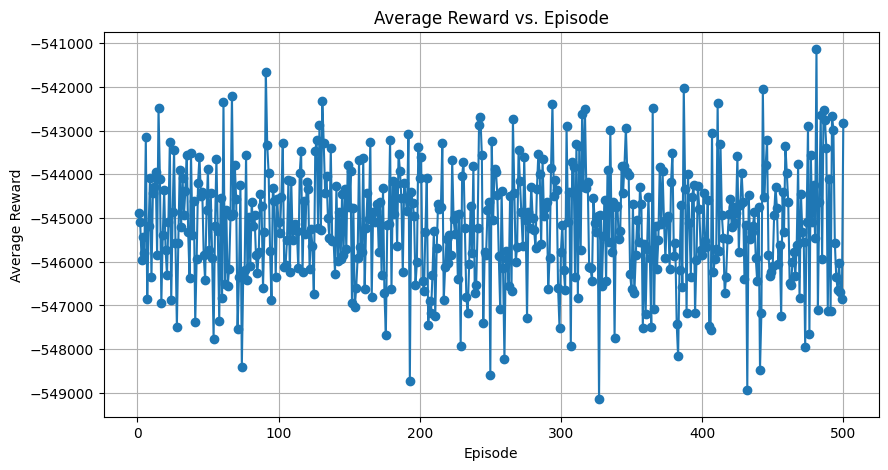

In [118]:
import numpy as np
import matplotlib.pyplot as plt
import torch

def evaluate_model_and_plot(env, policy_net, num_episodes=500):
    total_rewards = []
    for ep in range(num_episodes):
        state = env.reset()
        done = False
        total_reward = 0
        while not done:
            state_tensor = torch.tensor(state, dtype=torch.float32).unsqueeze(0)
            with torch.no_grad():
                distribution = policy_net(state_tensor)
                action = distribution.sample()
            action = action.squeeze().numpy()  
            state, reward, done, _ = env.step(action)
            total_reward += reward
        total_rewards.append(total_reward)
        print(f'Episode {ep+1}: Reward = {total_reward}')

    plt.figure(figsize=(10, 5))
    plt.plot(range(1, num_episodes+1), total_rewards, marker='o', linestyle='-')
    plt.title('Average Reward vs. Episode')
    plt.xlabel('Episode')
    plt.ylabel('Average Reward')
    plt.grid(True)
    plt.show()

    return total_rewards

rewards_history = evaluate_model_and_plot(env, policy_net)
